# Modelo de Clasificación de Imagenes Útiles/No Útiles
### Carlos Javier Leal Beltran A01741355
### Carlos Moises Chavez Jimenez A01637322
### Ernesto Adrian Alvarez Salazar A00227490
### Luis Armando Salazar Lopez A0114901

Desarrollarémos una red convolucional pre-entrenada para clasificar imagenes entre útiles y no útiles.


## 0.- Librerías y Permisos

In [1]:
# Importaremos todas las librerías necesarias para nuestro código.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy.stats
import tensorflow as tf
from matplotlib import pyplot
import os
import cv2
import math


from numpy import expand_dims
from sklearn.model_selection import KFold
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.utils import to_categorical, array_to_img, img_to_array, load_img
from keras.datasets import fashion_mnist
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.- Entrenamiento y evaluación del modelo generado.

### Función para mostrar las imagenes con las que se va trabajando.

In [ ]:
def plots(ims, is_bgr=False, figsize=(12,6), rows=1, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        if is_bgr:
            plt.imshow(bgr_to_rgb(ims[i]), interpolation=None if interp else 'none')
        else:
            plt.imshow(ims[i], interpolation=None if interp else 'none')

### Importación de imagenes para training, validation y testing.

A la par que importamos las fotografías, también definimos el tamaño inicial y el batch size para el entrenamiento del modelo.

In [6]:
# dimensions of our images.
img_width, img_height = 512, 512

train_data_dir = '/content/drive/Shareddrives/Caudales - Concentración/Imagenes/Train'
validation_data_dir = '/content/drive/Shareddrives/Caudales - Concentración/Imagenes/Validacion'
test_data_dir = '/content/drive/Shareddrives/Caudales - Concentración/Imagenes/Test'
nb_train_samples = 571
nb_validation_samples = 568
batch_size = 8

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=True,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    shuffle=True,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 571 images belonging to 2 classes.
Found 568 images belonging to 2 classes.
Found 571 images belonging to 2 classes.


### Mostramos las imagenes con las que se va a trabajar.

(8, 512, 512, 3)


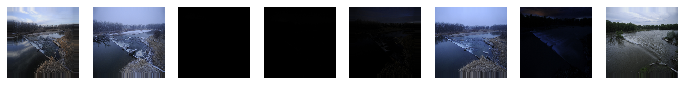

In [ ]:
bx, by = next(train_generator)
print(bx.shape)
plots([bx[i] for i in range(bx.shape[0])], rows=1)

### Definimos las capas de nuestro modelo y agregamos el modelo prentrenado.

Elegímos ResNet101V2 porque fue el que tuvo mejor performance al momento de entrenar.

In [ ]:
nclass = len(train_generator.class_indices)
base_model = tf.keras.applications.ResNet101V2(weights='imagenet', 
                                include_top=False, 
                                input_shape=(512, 512, 3))
add_model = Sequential()
add_model.add(base_model)
add_model.add(Conv2D(64, (3, 3)))
add_model.add(Flatten())
add_model.add(Dense(64))
add_model.add(Activation('relu'))
add_model.add(Dropout(0.5))
add_model.add(Dense(nclass))
add_model.add(Activation('softmax'))

model = add_model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])
model.summary()

171317808/171317808 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 16, 16, 2048)      42626560  
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1179712   
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 64)                802880    
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                       

### Definimos las características del entrenamiento que tendrá el modelo.

Vamos a definir solamente 5 epocas para el modelo dados los recursos tan limitados con los que contamos. Además, agregaremos un earlystopping en caso de detectar overfitting y un checkpoint que nos permitirá guardar el mejor modelo.

In [ ]:
file_path="/content/drive/Shareddrives/Caudales - Concentración/Reto/model.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early = EarlyStopping(monitor="accuracy", mode="max", patience=3)

callbacks_list = [checkpoint, early] #early

history = model.fit(train_generator, 
                    epochs=5,
                    verbose=True,
                    steps_per_epoch=nb_train_samples // batch_size,
                    callbacks=callbacks_list,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size)

Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 0.2706 - accuracy: 0.9165

71/71 [==============================] - 963s 13s/step - loss: 0.2706 - accuracy: 0.9165 - val_loss: 0.3144 - val_accuracy: 0.9349
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9911

71/71 [==============================] - 279s 4s/step - loss: 0.0266 - accuracy: 0.9911 - val_loss: 0.3591 - val_accuracy: 0.9454
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9911

71/71 [==============================] - 281s 4s/step - loss: 0.0221 - accuracy: 0.9911 - val_loss: 0.4313 - val_accuracy: 0.9454
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9982

71/71 [==============================] - 279s 4s/step - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.4767 - val_accuracy: 0.9454
Epoch 5/5
71/71 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9929

71/71 [==============================] - 278s 4s/step - loss: 0.0156 - accuracy: 0.9929 - val_loss: 0.5579 - val_accuracy: 0.9507


### Graficarémos el accuracy y loss de nuestro entrenamiento.

In [ ]:
# Run to load the model history into a pandas DataFrame
accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(accuracy))

<Figure size 432x288 with 0 Axes>

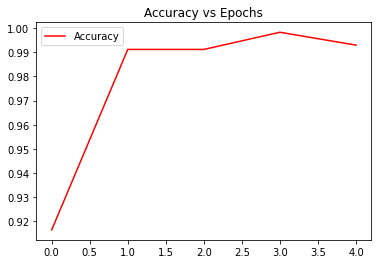

<Figure size 432x288 with 0 Axes>

In [ ]:
# Run to make the Accuracy vs Epochs plot
plt.plot(epochs, accuracy, 'r', label='Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

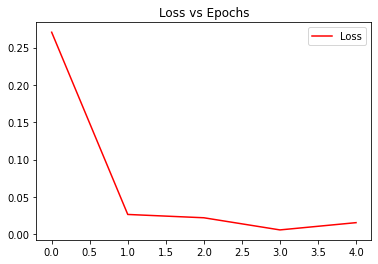

<Figure size 432x288 with 0 Axes>

In [ ]:
# Run to make the Loss vs Epochs plot
plt.plot(epochs, loss, 'r', label='Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.figure()

### Evaluarémos el modelo con las imagenes preclasificadas que tenémos.

In [ ]:
test_eval = model.evaluate(test_generator,verbose=0)
print('Test Loss: ',test_eval[0])
print('Test Accuracy: ',test_eval[1])

Test Loss:  0.003451394848525524
Test Accuracy:  0.9982486963272095


### Guardamos el modelo generado.

In [ ]:
model.save('/content/drive/Shareddrives/Caudales - Concentración/Reto/model_predicted2') 

### Lo cargaremos, en caso de que no queramos volverlo a entrenar.

In [3]:
model = keras.models.load_model('/content/drive/Shareddrives/Caudales - Concentración/Reto/model_predicted2')

### Harémos la predicción de las imágenes evaluadas.

In [ ]:
predict = model.predict(test_generator)

72/72 [==============================] - 134s 2s/step


In [ ]:
print(predict)

[[4.2669373e-13 1.0000000e+00]
 [1.0000000e+00 1.7029185e-10]
 [9.9745458e-01 2.5453628e-03]
 ...
 [1.6022113e-10 1.0000000e+00]
 [1.0000000e+00 8.5884591e-11]
 [1.4463742e-06 9.9999857e-01]]


Clasificarémos la predicción para que quede en un solo número de la clase que se le asignó.

In [ ]:
predicted = []
for pred in predict:
    if pred[0] > pred[1]:
        predicted.append(0)
    else:
        predicted.append(1)

### Generarémos la matriz de confusión que nos indica la efectividad de la predicción.

En este caso, le costó trabajo distinguir las imágenes incorrectas.

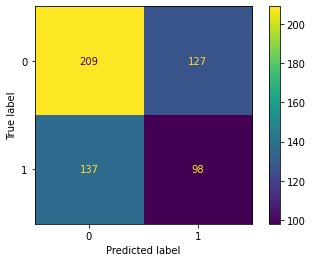

In [ ]:
CM = confusion_matrix(train_generator.labels,predicted)
disp = ConfusionMatrixDisplay(CM)
disp.plot()

## 2.- Clasificación de imagenes de temporadas consecutivas

In [12]:
predict_data_dir = '/content/drive/Shareddrives/Caudales - Concentración/Imagenes/Prediction/Two Consecutive Seasons'

In [13]:
image_generator = test_datagen.flow_from_directory(
    predict_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 1998 images belonging to 2 classes.


In [15]:
predict = model.predict(image_generator)

250/250 [==============================] - 458s 2s/step


In [16]:
print(predict)

[[1.0000000e+00 4.0537937e-10]
 [1.0000000e+00 3.6630674e-09]
 [9.9995530e-01 4.4685465e-05]
 ...
 [1.0000000e+00 3.2071451e-10]
 [1.0000000e+00 2.8585651e-11]
 [2.3618938e-13 1.0000000e+00]]


In [17]:
two_season_list = []
for pred in predict:
  if pred[0] >= pred[1]:
    two_season_list.append(0)
  else:
    two_season_list.append(1)

print(two_season_list)

[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [18]:
ans = []
for file, pred in zip(image_generator.filenames,two_season_list):
    file = file.replace('20190804', '',1)
    file = file.replace('20190920', '',1)
    file = file.replace(' (1)', '',1)
    file = file.replace('/', '')
    if pred == 1:
      ans.append([file])
print(ans)

[['20170303StateLineWeir_20170303_Farrell_008.jpg'], ['20170303StateLineWeir_20170303_Farrell_010.jpg'], ['20170303StateLineWeir_20170304_Farrell_019.jpg'], ['20170303StateLineWeir_20170304_Farrell_033.jpg'], ['20170303StateLineWeir_20170304_Farrell_035.jpg'], ['20170303StateLineWeir_20170304_Farrell_036.jpg'], ['20170303StateLineWeir_20170304_Farrell_042.jpg'], ['20170303StateLineWeir_20170305_Farrell_045.jpg'], ['20170303StateLineWeir_20170305_Farrell_047.jpg'], ['20170303StateLineWeir_20170305_Farrell_065.jpg'], ['20170303StateLineWeir_20170306_Farrell_079.jpg'], ['20170303StateLineWeir_20170306_Farrell_083.jpg'], ['20170303StateLineWeir_20170306_Farrell_087.jpg'], ['20170303StateLineWeir_20170306_Farrell_089.jpg'], ['20170303StateLineWeir_20170306_Farrell_094.jpg'], ['20170303StateLineWeir_20170307_Farrell_109.jpg'], ['20170303StateLineWeir_20170307_Farrell_112.jpg'], ['20170303StateLineWeir_20170307_Farrell_113.jpg'], ['20170303StateLineWeir_20170308_Farrell_128.jpg'], ['20170303S

In [19]:
np.savetxt("/content/drive/Shareddrives/Caudales - Concentración/Reto/Dataset/consecutive_seasons.csv", 
           ans,
           delimiter =", ", 
           fmt ='% s')

## 3.- Clasificación de imagenes de temporadas de diferentes años.

In [20]:
predict_data_dir = '/content/drive/Shareddrives/Caudales - Concentración/Imagenes/Prediction/Two Different Seasons'

In [21]:
image_generator = test_datagen.flow_from_directory(
    predict_data_dir,
    shuffle=True,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 1998 images belonging to 2 classes.


In [23]:
predict = model.predict(image_generator)

250/250 [==============================] - 2630s 11s/step


In [24]:
print(predict)

[[1.0000000e+00 2.4884508e-09]
 [5.6761152e-01 4.3238848e-01]
 [1.0000000e+00 1.5273294e-08]
 ...
 [9.9999189e-01 8.0925711e-06]
 [9.9999988e-01 1.6470574e-07]
 [9.9996686e-01 3.3140757e-05]]


In [25]:
two_season_list = []
for pred in predict:
  if pred[0] >= pred[1]:
    two_season_list.append(0)
  else:
    two_season_list.append(1)

print(two_season_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 

In [26]:
ans = []
for file, pred in zip(image_generator.filenames,two_season_list):
    file = file.replace('20190624', '',1)
    file = file.replace('20130803', '',1)
    file = file.replace(' (1)', '',1)
    file = file.replace('/', '')
    if pred == 1:
      ans.append([file])
print(ans)

[['StateLineWeir_20130804_Farrell_020.JPG'], ['StateLineWeir_20130804_Farrell_021.JPG'], ['StateLineWeir_20130805_Farrell_025.JPG'], ['StateLineWeir_20130805_Farrell_031.JPG'], ['StateLineWeir_20130806_Farrell_043.JPG'], ['StateLineWeir_20130806_Farrell_052.JPG'], ['StateLineWeir_20130807_Farrell_074.JPG'], ['StateLineWeir_20130808_Farrell_079.JPG'], ['StateLineWeir_20130808_Farrell_090.JPG'], ['StateLineWeir_20130809_Farrell_106.JPG'], ['StateLineWeir_20130810_Farrell_109.JPG'], ['StateLineWeir_20130810_Farrell_120.JPG'], ['StateLineWeir_20130811_Farrell_133.JPG'], ['StateLineWeir_20130811_Farrell_139.JPG'], ['StateLineWeir_20130812_Farrell_151.JPG'], ['StateLineWeir_20130813_Farrell_161.JPG'], ['StateLineWeir_20130814_Farrell_182.JPG'], ['StateLineWeir_20130814_Farrell_183.JPG'], ['StateLineWeir_20130815_Farrell_198.JPG'], ['StateLineWeir_20130815_Farrell_200.JPG'], ['StateLineWeir_20130816_Farrell_204.JPG'], ['StateLineWeir_20130816_Farrell_210.JPG'], ['StateLineWeir_20130816_Farrel

In [27]:
np.savetxt("/content/drive/Shareddrives/Caudales - Concentración/Reto/Dataset/different_seasons.csv", 
           ans,
           delimiter =", ", 
           fmt ='% s')